In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize a full MDP episode

In [6]:
from single.basics import generate_simple_instance
from single.mdp import SingleScheduleEnv
import numpy as np
import os

# make sure 'figures' folder exists
os.makedirs('figures', exist_ok=True)

# some instance
s = generate_simple_instance(n=[1,2])

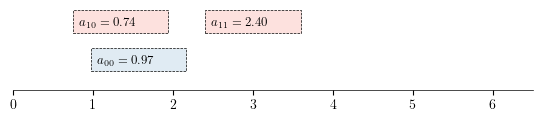

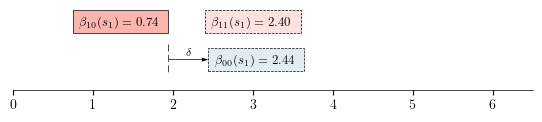

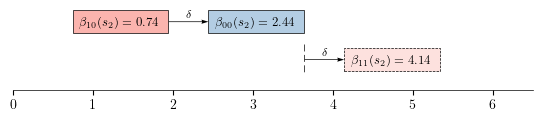

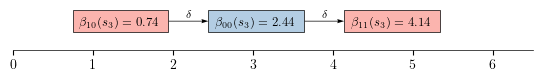

In [7]:
# create the MDP ("environment")
options = {
    'collapse_current': True,
    'fixed_end': 6.5,
    'tex': True,
    'out': 'figures/episode{t}.pdf'
}
env = SingleScheduleEnv(instance=s, options=options)
obs, info = env.reset()
env.action_space.seed(12) # to keep the same example once we like it
env.render()

done = False
while not done:
    # mask = valid actions = routes with unscheduled vehicles
    mask = (~obs['done']).astype(np.int8)
    action = env.action_space.sample(mask)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

In [8]:
import fitz  # PyMuPDF

pdfs = [f'figures/episode{t}.pdf' for t in range(env.t + 1)]
docs = [fitz.open(path) for path in pdfs]
pages = [doc.load_page(0) for doc in docs]

# gap between source pages
gap = 25

# compute total output size
width = max(page.rect.width for page in pages)
height = sum(page.rect.height for page in pages) + gap * (len(pages) - 1)

# create an output document and one large page
out = fitz.open()
out_page = out.new_page(width=width, height=height)

# paste each PDF page below the previous one
y = 0
for doc, page in zip(docs, pages):
    rect = page.rect

    # draw border rectangle
    # page.draw_rect(
    #     rect,
    #     color=(0.5, 0.5, 0.5),
    #     width=1,           # border line width in points
    # )

    out_page.show_pdf_page(
        fitz.Rect(0, y, rect.width, y + rect.height),  # target rectangle
        doc,                                           # source document
        0                                              # source page number
    )
    y += rect.height + gap

# save and close everything
out.save("figures/episode.pdf")
for d in docs:
    d.close()
out.close()
